In [71]:
# ==============================================
# 1) Import Libraries and Initialize Environment
# ==============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk, re, string, json
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
import spacy
import sys
from collections import Counter

try:
    from transformers import pipeline
    HAS_TRANSFORMERS = True
except Exception:
    HAS_TRANSFORMERS = False

In [72]:
# ============================================
# 2) Load Dataset and Validate Structure
# ============================================
def load_data(path):
    df = pd.read_csv(path)
    if 'review_text' not in df.columns:
        raise ValueError("CSV must include 'review_text' column")
    if 'rating' not in df.columns:
        df['rating'] = np.nan
    if 'bank' not in df.columns:
        df['bank'] = 'unknown'
    return df

df = load_data("../data/processed/reviews_processed.csv")
df.head()

,review_id,review_text,rating,review_date,review_year,review_month,bank_code,bank_name,user_name,thumbs_up,text_length,source,bank
0,809c46d2-730e-446a-9061-2a45e978ad9d,good jop,5,2025-11-27,2025,11,Abyssinia,Abyssinia Bank,Yohanis Fikadu,0,8,Google Play,unknown
1,63f63b8b-016a-4262-a27e-f0de9ebf985a,ok,5,2025-11-27,2025,11,Abyssinia,Abyssinia Bank,Butu Mare,0,2,Google Play,unknown
2,f28a3a3c-eb94-4aab-88d2-89bcecebcc7b,bad exprience...it is so crushed,1,2025-11-27,2025,11,Abyssinia,Abyssinia Bank,ሻንበል ኪዳነ,0,32,Google Play,unknown
3,4ed89e8c-16dc-4763-94ca-04d05cf799a5,not user friendly at all it requires a huge co...,1,2025-11-26,2025,11,Abyssinia,Abyssinia Bank,Tsegaw Fikru,0,82,Google Play,unknown
4,f5bfd792-bc81-4d06-99c9-06c7743d3e09,,1,2025-11-26,2025,11,Abyssinia,Abyssinia Bank,Elsa Tesfay,0,2,Google Play,unknown


In [73]:
# ============================================
# 3) Text Preprocessing and Cleaning
# ============================================
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

STOP = set(nltk.corpus.stopwords.words('english'))
nlp_spacy = spacy.load("en_core_web_sm", disable=["parser","ner"])

def clean_text(text, do_lemmatize=True):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    if do_lemmatize:
        doc = nlp_spacy(text)
        tokens = [token.lemma_ for token in doc if token.text not in STOP and token.is_alpha]
        return " ".join(tokens)
    else:
        tokens = [t for t in nltk.word_tokenize(text) if t not in STOP and t.isalpha()]
        return " ".join(tokens)

df['clean_text'] = df['review_text'].astype(str).apply(clean_text)
df.head()


[nltk_data] Downloading package vader_lexicon to C:\Users\HP
[nltk_data]     EliteBook\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\HP
[nltk_data]     EliteBook\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\HP
[nltk_data]     EliteBook\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review_id,review_text,rating,review_date,review_year,review_month,bank_code,bank_name,user_name,thumbs_up,text_length,source,bank,clean_text
0,809c46d2-730e-446a-9061-2a45e978ad9d,good jop,5,2025-11-27,2025,11,Abyssinia,Abyssinia Bank,Yohanis Fikadu,0,8,Google Play,unknown,good jop
1,63f63b8b-016a-4262-a27e-f0de9ebf985a,ok,5,2025-11-27,2025,11,Abyssinia,Abyssinia Bank,Butu Mare,0,2,Google Play,unknown,ok
2,f28a3a3c-eb94-4aab-88d2-89bcecebcc7b,bad exprience...it is so crushed,1,2025-11-27,2025,11,Abyssinia,Abyssinia Bank,ሻንበል ኪዳነ,0,32,Google Play,unknown,bad exprienceit crushed
3,4ed89e8c-16dc-4763-94ca-04d05cf799a5,not user friendly at all it requires a huge co...,1,2025-11-26,2025,11,Abyssinia,Abyssinia Bank,Tsegaw Fikru,0,82,Google Play,unknown,user friendly require huge connectivity also l...
4,f5bfd792-bc81-4d06-99c9-06c7743d3e09,,1,2025-11-26,2025,11,Abyssinia,Abyssinia Bank,Elsa Tesfay,0,2,Google Play,unknown,


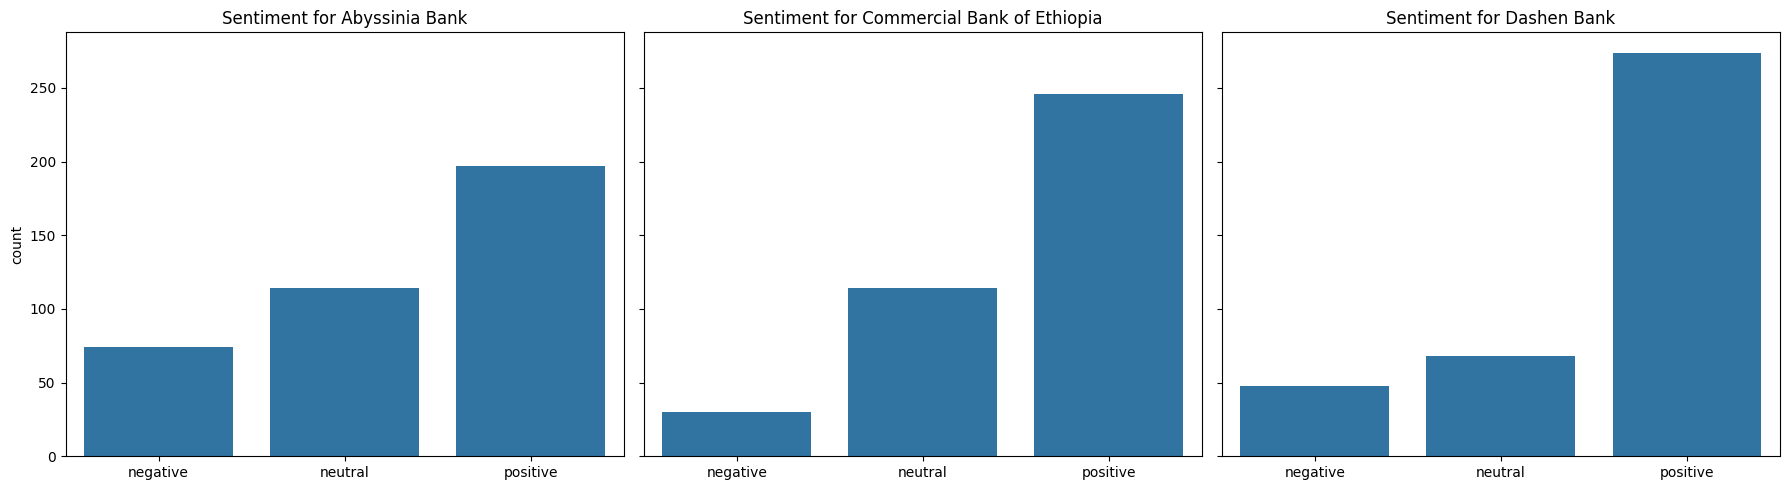

In [74]:
# ============================================
# 4) Lexicon-Based Sentiment Analysis & Visualization per Bank
# ============================================
df = lexicon_sentiments(df)
banks = df['bank_name'].unique()[:3]
fig, axes = plt.subplots(1, len(banks), figsize=(18,5), sharey=True)
axes = np.atleast_1d(axes)

for i, bank in enumerate(banks):
    sns.countplot(
        x="lexicon_label",
        data=df[df['bank_name'] == bank],
        ax=axes[i],
        order=["negative","neutral","positive"]  
    )
    axes[i].set_title(f"Sentiment for {bank}")
    axes[i].set_xlabel("")
    if i != 0:
        axes[i].set_ylabel("")

plt.tight_layout()
plt.show()

In [ ]:
# ----------------------------
# Transformer-based Sentiment Analysis
# ----------------------------
from transformers import pipeline

try:
    classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
    
    preds = classifier(df['review_text'].astype(str).tolist())

    df['distilbert_label'] = [p['label'].lower() for p in preds]
    df['distilbert_score'] = [(p['score'] if p['label']=='POSITIVE' else -p['score']) for p in preds]

    if 'distilbert_score' in df.columns and df['distilbert_score'].notna().any():
        sns.histplot(df['distilbert_score'], bins=20)
        plt.title("DistilBERT Sentiment Score Distribution")
        plt.show()
    else:
        print("No distilbert_score available to plot.")

except Exception as e:
    print("Error with DistilBERT sentiment analysis:", e)

Error with DistilBERT sentiment analysis: name 'torch' is not defined


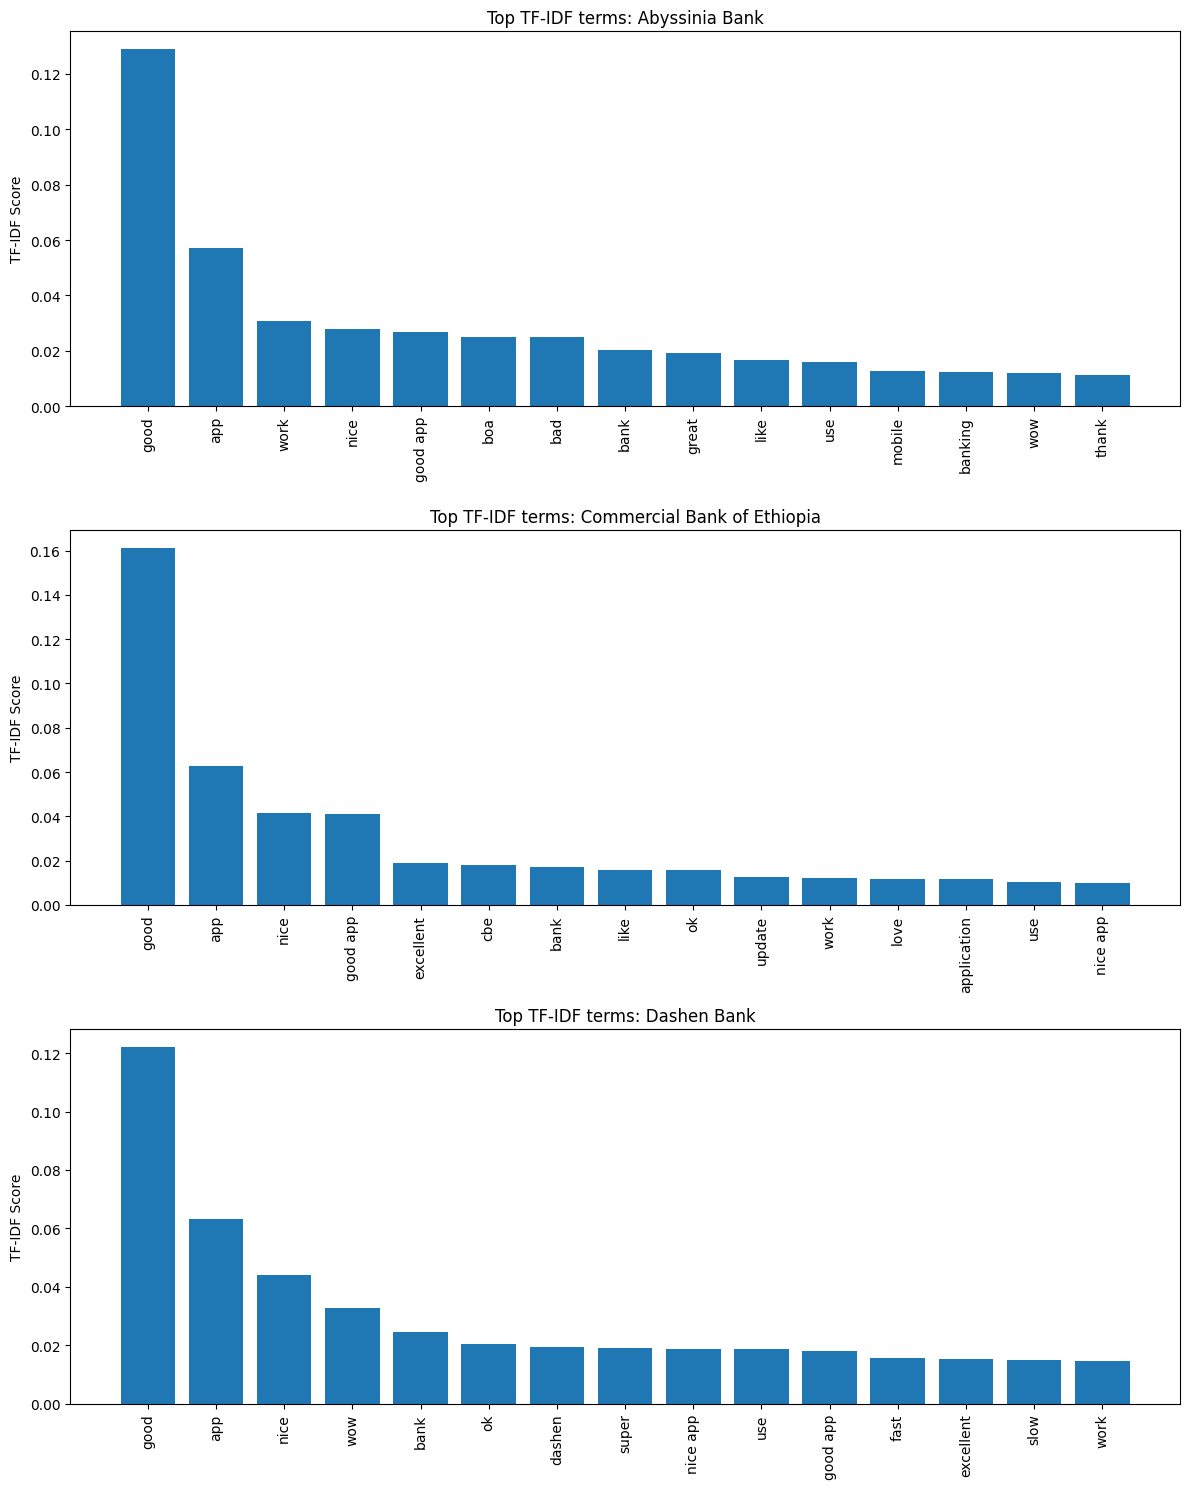

In [76]:
# ============================================
# 5) Extract and Visualize Top TF-IDF Keywords per Bank
# ============================================
def get_tfidf_keywords(df, text_col='clean_text', top_k=30):
    tfidf = TfidfVectorizer(ngram_range=(1,2), stop_words='english', max_features=2000)
    X = tfidf.fit_transform(df[text_col].fillna(''))
    feature_names = np.array(tfidf.get_feature_names_out())
    mean_tfidf = np.asarray(X.mean(axis=0)).flatten()
    top_idx = mean_tfidf.argsort()[::-1][:top_k]
    return [(feature_names[i], float(mean_tfidf[i])) for i in top_idx]

banks = df['bank_name'].unique()

fig, axes = plt.subplots(len(banks), 1, figsize=(12, 5*len(banks)), sharey=False)
axes = np.atleast_1d(axes)

for i, bank in enumerate(banks):
    df_bank = df[df['bank_name'] == bank]
    top_terms = get_tfidf_keywords(df_bank, text_col='clean_text', top_k=15)
    
    terms, scores = zip(*top_terms)
    axes[i].bar(terms, scores)
    axes[i].set_title(f"Top TF-IDF terms: {bank}")
    axes[i].set_ylabel("TF-IDF Score")
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [77]:
# ============================================
# 6) LDA Topic Modeling per Bank
# ============================================
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

for bank in df['bank_name'].unique():
    print("======================================")
    print(f"   LDA Topics for {bank}")
    print("======================================")

    bank_df = df[df['bank_name'] == bank]
    texts = [t.split() for t in bank_df['clean_text'].astype(str)]
    if len(texts) < 5:
        print("Not enough data for LDA.\n")
        continue

    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    lda = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=3,
        passes=8,
        random_state=42
    )

    for i in range(3):
        print(f"\nTopic {i+1}:")
        print(lda.show_topic(i, topn=10))

    print("\n\n")

   LDA Topics for Abyssinia Bank

Topic 1:
[('app', np.float32(0.03788289)), ('not', np.float32(0.024634192)), ('bank', np.float32(0.024432415)), ('transfer', np.float32(0.014050502)), ('use', np.float32(0.012875588)), ('fast', np.float32(0.012430074)), ('money', np.float32(0.0122046005)), ('slow', np.float32(0.00987843)), ('time', np.float32(0.009510184)), ('open', np.float32(0.009464866))]

Topic 2:
[('app', np.float32(0.027558714)), ('boa', np.float32(0.019600285)), ('nice', np.float32(0.018998653)), ('bank', np.float32(0.014350577)), ('developer', np.float32(0.013990804)), ('use', np.float32(0.013265281)), ('phone', np.float32(0.01312478)), ('even', np.float32(0.012182307)), ('please', np.float32(0.012026164)), ('great', np.float32(0.011985814))]

Topic 3:
[('app', np.float32(0.080428645)), ('good', np.float32(0.060041934)), ('not', np.float32(0.025132021)), ('work', np.float32(0.023692446)), ('bad', np.float32(0.021473013)), ('bank', np.float32(0.01648169)), ('like', np.float32(0.

In [78]:
# ============================================
# 7) Map LDA Terms to Themes and Assign to Reviews
# ============================================
top_terms = []
for t in range(3):
    top_terms.extend(lda.show_topic(t, topn=10))   


DEFAULT_THEME_KEYWORDS = {
    "Account Access Issues": ["login","password","blocked","access","otp"],
    "Transaction Performance": ["transfer","pending","failed","transaction","timeout"],
    "UI & UX": ["ui","design","interface","navigation","layout"],
    "Stability & Crashes": ["crash","bug","freeze","error"],
    "Customer Support": ["support","service","call","help","agent"],
    "Feature Requests": ["feature","add","integration","payment","qr"]
}


def map_themes_from_keywords(keywords_list, theme_map=DEFAULT_THEME_KEYWORDS):
    term_to_theme = {}
    for term, _ in keywords_list:
        matched = [theme for theme, kws in theme_map.items() if any(kw in term for kw in kws)]
        term_to_theme[term] = matched if matched else ["Other"]
    return term_to_theme

term_to_theme = map_themes_from_keywords(top_terms)

def assign_review_themes(df, term_to_theme, text_col='clean_text'):
    def find_themes(text):
        themes = []
        for term, mapped in term_to_theme.items():
            if term in text:
                themes.extend(mapped)
        return list(set(themes)) or ["Other"]
    df['identified_themes'] = df[text_col].apply(find_themes)
    return df
df = assign_review_themes(df, term_to_theme)

print(df[['review_text', 'identified_themes']].head(10))

                                         review_text identified_themes
0                                           good jop           [Other]
1                                                 ok           [Other]
2                   bad exprience...it is so crushed           [Other]
3  not user friendly at all it requires a huge co...           [Other]
4                                                              [Other]
5                                          very good           [Other]
6           most of the time is not working properly           [Other]
7                                       good service           [Other]
8                                     not use for me           [Other]
9  It keeps notifying me to disable developer opt...           [Other]


In [ ]:
# ====================================================
# 8) Bank metadata integration and final data export
# ====================================================
bank_meta = pd.DataFrame([
    ["com.combanketh.mobilebanking", "Commercial Bank of Ethiopia", 4.321625, 38837, 8333, "5,000,000+", "CBE", "Commercial Bank of Ethiopia"],
    ["com.boa.boaMobileBanking", "BoA Mobile", 4.1912227, 6326, 1219, "1,000,000+", "Abyssinia", "Abyssinia Bank"],
    ["com.dashen.dashensuperapp", "Dashen Bank", 4.169666, 3895, 769, "1,000,000+", "Dashen", "Dashen Bank"]
], columns=["app_id","title","score","ratings","reviews","installs","bank_code","bank_name"])

# Merge review data with bank metadata on 'bank_name'
final_df = pd.merge(df, bank_meta, on='bank_name', how='left')

# Save to CSV
final_df.to_csv("../data/processed/final_cleaned_reviewed.csv", index=False)
print("✅ Final cleaned and enriched data saved to 'final_cleaned_reviewed.csv'")

✅ Final cleaned and enriched data saved to 'final_cleaned_reviewed.csv'
